BitcoinHeistRansomwareAddressDataset Data Set


https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset

Shakiba

Install two Python libraries, pyspark and findspark,

In [1]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=7733f46f7199e6cec6fac3726e26ed7867013e84abb7ec39fabf80208073a265
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


Imports various libraries for data preprocessing, feature engineering, model training, evaluation, and visualization in a Jupyter Notebook environment with Apache Spark.

In [3]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
findspark.init()

from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover, OneHotEncoder
from pyspark.sql.functions import col, udf, regexp_replace, isnull, isnan, when, count
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F


from sklearn.model_selection import train_test_split, GridSearchCV
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes

from sklearn.pipeline import Pipeline
from pyspark.ml.pipeline import Pipeline


from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns


Initialize default configs using SparkSession

In [4]:
spark = SparkSession.builder.master("local").appName("bitcoinheist").config("spark.executor.memory", "1gb").getOrCreate()

In [5]:
sc = spark.sparkContext

In [6]:
ls

BitcoinHeistData.csv  sample_data/


Load dataset from local machine as a csv file

In [7]:
df = spark.read.csv('BitcoinHeistData.csv', inferSchema='True', header = 'True')

Display top 20 rows

In [8]:
df.show(20)

+--------------------+----+---+------+-------------------+-----+------+---------+--------+--------------------+
|             address|year|day|length|             weight|count|looped|neighbors|  income|               label|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+--------------------+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|1.0005E8|     princetonCerber|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|   1.0E8|      princetonLocky|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|   2.0E8|     princetonCerber|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2|  7.12E7|     princetonCerber|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|   2.0E8|      princetonLocky|
|112AmFATxzhuSpvtz...|2016| 96|   144| 0.0846139993386755| 2821|     0|        1|   5.0E7|      princeto

In [9]:
df.printSchema()

root
 |-- address: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- looped: integer (nullable = true)
 |-- neighbors: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- label: string (nullable = true)



Display the shape of DataSet

In [10]:
print("The dataset contains {} rows.".format(df.count()))
print("The dataset contains {} columns.".format((df.columns)))

The dataset contains 2916697 rows.
The dataset contains ['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income', 'label'] columns.


In [11]:
for c in df.columns:
  count(when(isnan(c), c)).alias(c)

Check null values from dataframe


In [12]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-------+----+---+------+------+-----+------+---------+------+-----+
|address|year|day|length|weight|count|looped|neighbors|income|label|
+-------+----+---+------+------+-----+------+---------+------+-----+
|      0|   0|  0|     0|     0|    0|     0|        0|     0|    0|
+-------+----+---+------+------+-----+------+---------+------+-----+



Converts a PySpark DataFrame (df) into a pandas DataFrame (df_pd) for plotting. Then identifies the feature columns by excluding non-feature columns ('address' and 'label'). For each feature column, it plots the distribution using a histogram with 30 bins and a kernel density estimate (KDE), and displays the plot with the corresponding feature name as the title.

In [13]:
# Convert to pandas DataFrame for plotting
df_pd = df.toPandas()

In [14]:
all_columns = df.columns  # Get a list of all columns in the DataFrame
non_feature_columns = ['address', 'label']  # List of non-feature columns

features = [col for col in all_columns if col not in non_feature_columns]  # Remove non-feature columns from the list


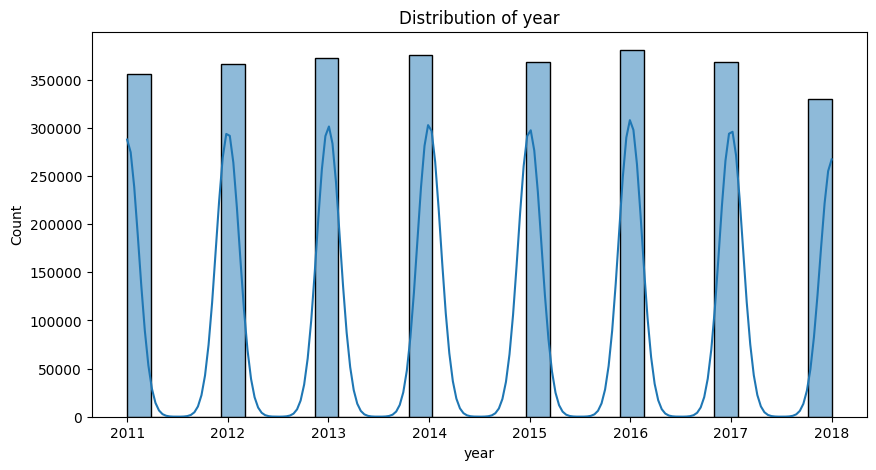

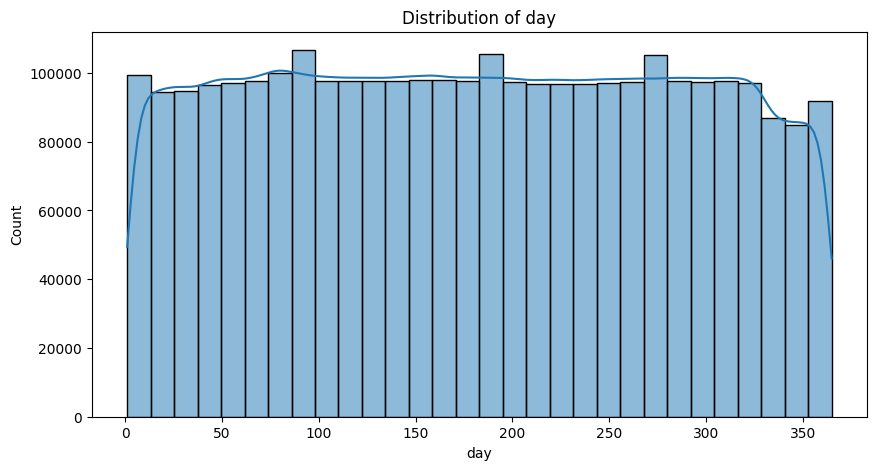

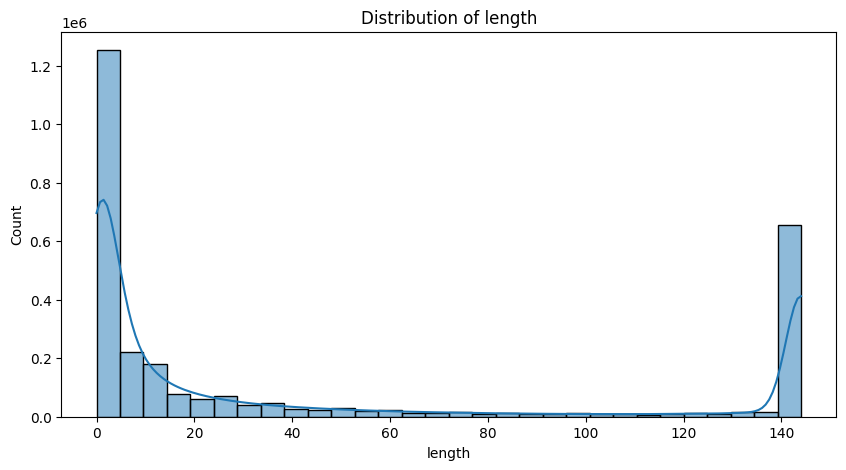

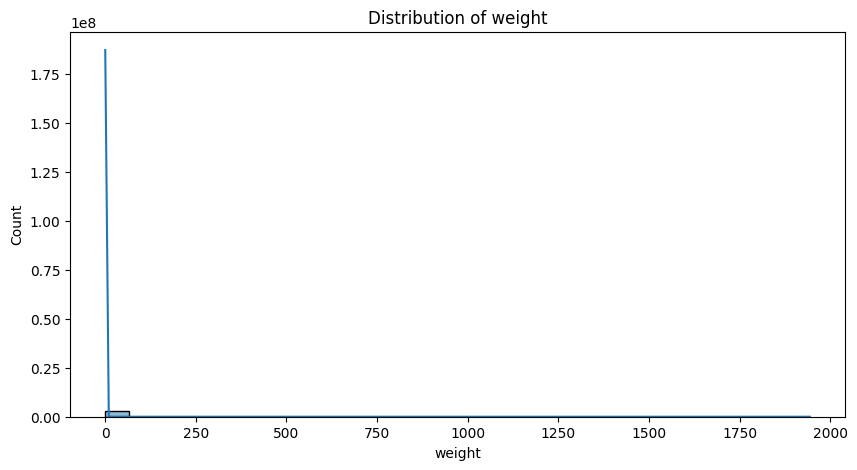

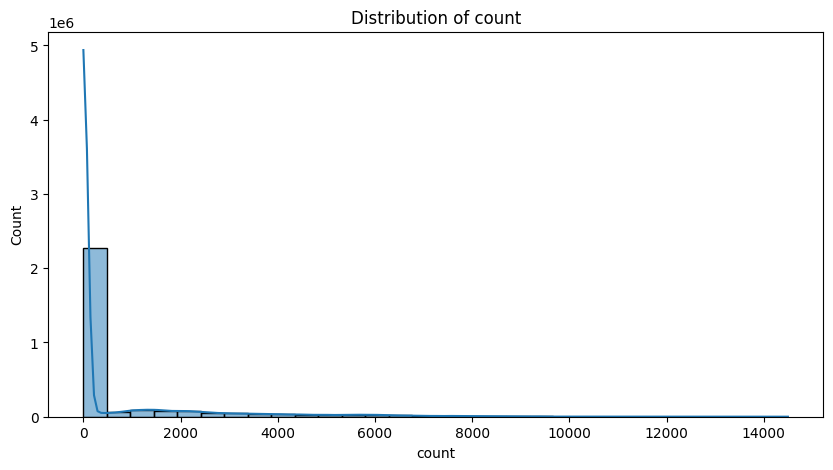

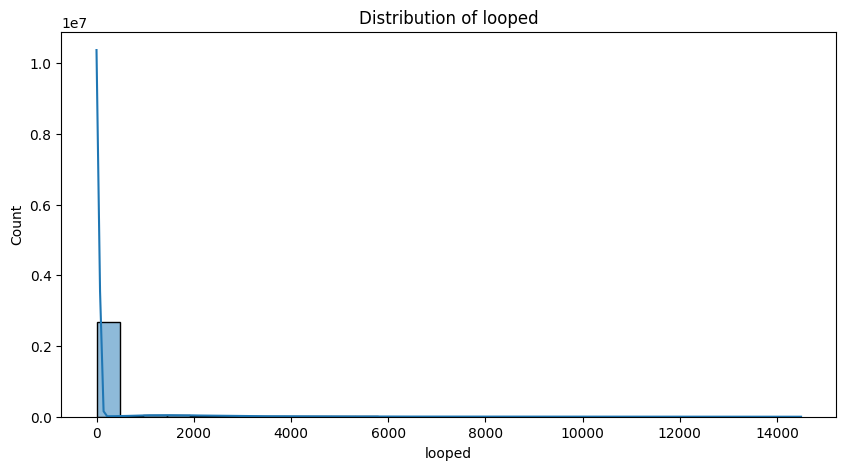

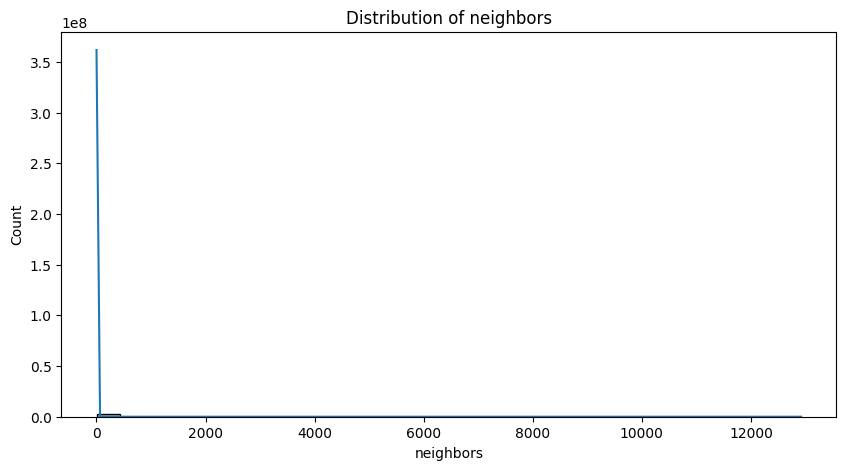

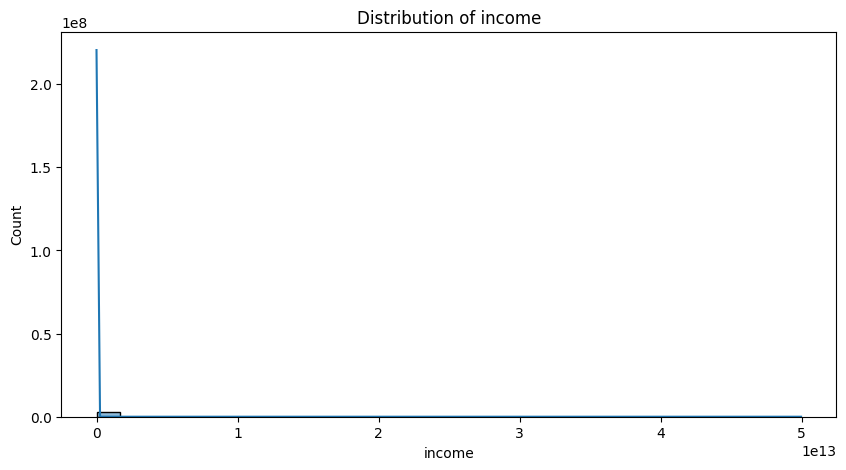

In [15]:
# Plotting the distributions of each feature
for feature in features:
    plt.figure(figsize=(10,5))
    sns.histplot(data=df_pd, x=feature, bins=30, kde=True)
    plt.title('Distribution of '+ feature)
    plt.show()

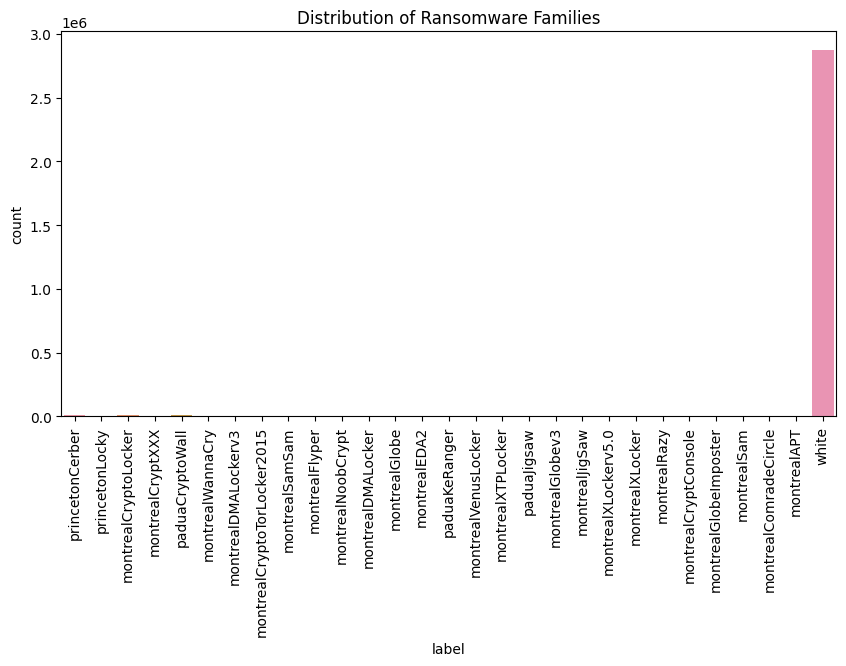

In [16]:
# Checking the distribution of the target variable
plt.figure(figsize=(10,5))
sns.countplot(data=df_pd, x='label')
plt.title('Distribution of Ransomware Families')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()


In [17]:
label_counts = df.groupBy('label').count().orderBy('count', ascending=False)
label_counts.show()

+--------------------+-------+
|               label|  count|
+--------------------+-------+
|               white|2875284|
|     paduaCryptoWall|  12390|
|montrealCryptoLocker|   9315|
|     princetonCerber|   9223|
|      princetonLocky|   6625|
|    montrealCryptXXX|   2419|
|   montrealNoobCrypt|    483|
| montrealDMALockerv3|    354|
|   montrealDMALocker|    251|
|      montrealSamSam|     62|
|montrealCryptoTor...|     55|
|montrealGlobeImpo...|     55|
|     montrealGlobev3|     34|
|       montrealGlobe|     32|
|    montrealWannaCry|     28|
|        montrealRazy|     13|
|         montrealAPT|     11|
|       paduaKeRanger|     10|
|      montrealFlyper|      9|
|   montrealXTPLocker|      8|
+--------------------+-------+
only showing top 20 rows



In [18]:
original_df = df

In [19]:
# Drop the 'label' column
df = df.drop('label')

In [20]:
label_to_numeric_udf = udf(lambda label: 0.0 if label == 'white' else 1.0, DoubleType())
original_df = original_df.withColumn('label', label_to_numeric_udf('label'))

In [21]:
n_df = original_df.toPandas()

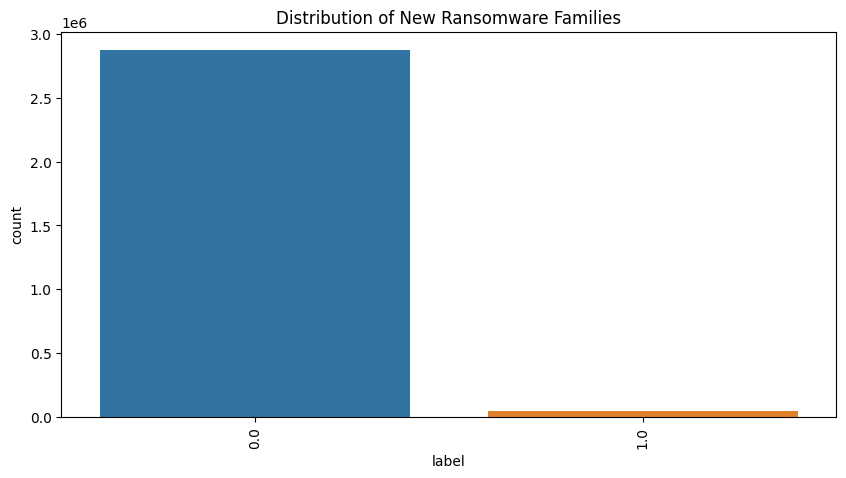

In [22]:
# Checking the distribution of the target variable
plt.figure(figsize=(10,5))
sns.countplot(data=n_df, x='label')
plt.title('Distribution of New Ransomware Families')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()

In [23]:
original_df.show()

+--------------------+----+---+------+-------------------+-----+------+---------+--------+-----+
|             address|year|day|length|             weight|count|looped|neighbors|  income|label|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+-----+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|1.0005E8|  1.0|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|   1.0E8|  1.0|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|   2.0E8|  1.0|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2|  7.12E7|  1.0|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|   2.0E8|  1.0|
|112AmFATxzhuSpvtz...|2016| 96|   144| 0.0846139993386755| 2821|     0|        1|   5.0E7|  1.0|
|112E91jxS2qrQY1z7...|2016|225|   142| 0.0020885186101272|  881|     0|        2|   1.0E8|  1.0|
|112eFykaD53KEkKeY...|2016|324

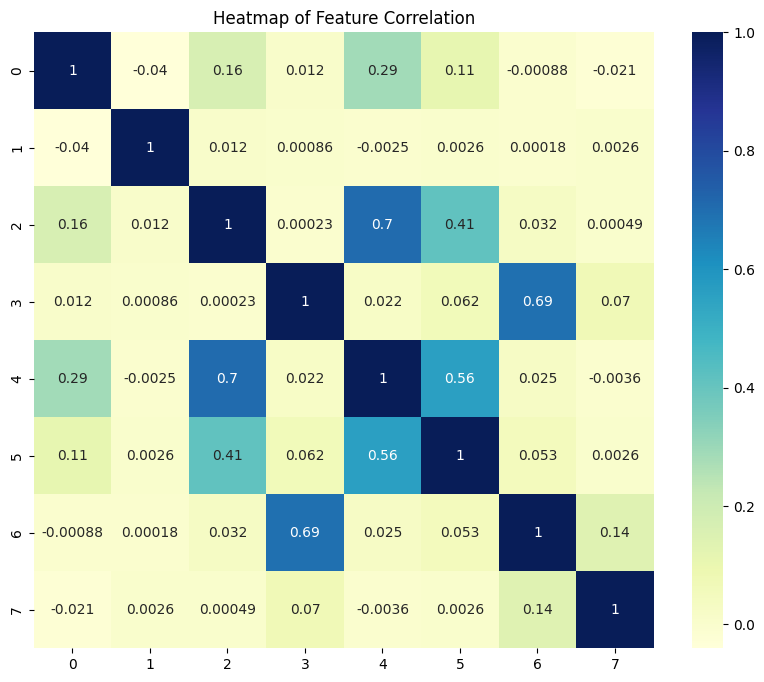

In [24]:
import pandas as pd

assembler = VectorAssembler(
    inputCols=["year", "day", "length", "weight", "count", "looped", "neighbors", "income"],
    outputCol="features")
vector_df = assembler.transform(df)

pearsonCorr = Correlation.corr(vector_df, "features").head()[0]

corr_df = pd.DataFrame(pearsonCorr.toArray())

plt.figure(figsize=(10,8))
sns.heatmap(corr_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Feature Correlation')
plt.show()

In [25]:
(train_data, test_data) = df.randomSplit([0.7, 0.3])

In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

assembler = VectorAssembler(inputCols=features, outputCol='features')

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [28]:
kmeans = KMeans(featuresCol='scaledFeatures', k=2)

pipeline = Pipeline(stages=[assembler, scaler, kmeans])

k_model = pipeline.fit(train_data)

k_predictions = k_model.transform(train_data)

k_predictions_with_labels = k_predictions.join(original_df.select(['address', 'label']), on='address')

In [29]:
majority_label_per_cluster = k_predictions_with_labels.groupBy('prediction', 'label').count()\
                                    .orderBy('prediction', F.desc('count'))\
                                    .dropDuplicates(['prediction'])\
                                    .withColumnRenamed('label', 'majority_label')

k_predictions_with_majority_label = k_predictions_with_labels.join(majority_label_per_cluster, on='prediction')

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="majority_label", metricName="accuracy")
accuracy = evaluator.evaluate(k_predictions_with_majority_label)

print("Train Accuracy = " + str(accuracy))

Train Accuracy = 0.8481799277992881


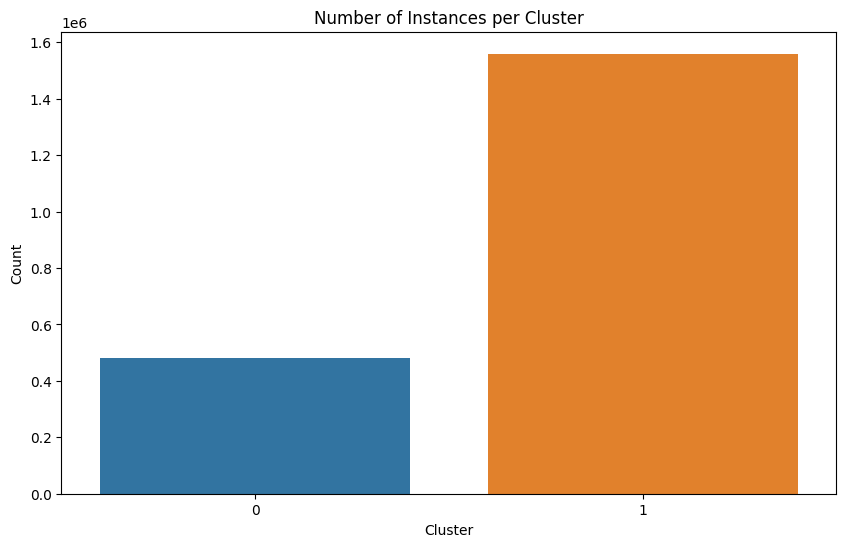

In [31]:
import seaborn as sns

cluster_counts = k_predictions.groupBy("prediction").count().toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="prediction", y="count", data=cluster_counts)
plt.title('Number of Instances per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


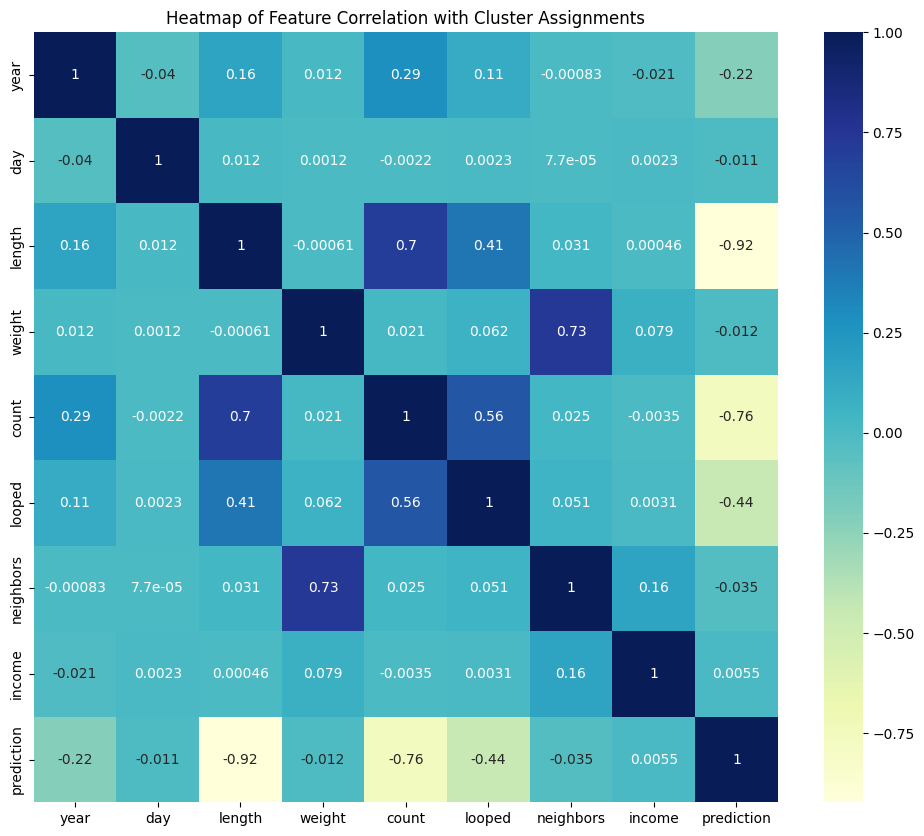

In [32]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


features_with_clusters = features + ["prediction"]

assembler = VectorAssembler(inputCols=features_with_clusters, outputCol='features_with_clusters')

vector_df = assembler.transform(k_predictions)

pearsonCorr = Correlation.corr(vector_df, "features_with_clusters").head()[0]

corr_df = pd.DataFrame(pearsonCorr.toArray(), columns=features_with_clusters, index=features_with_clusters)

import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(corr_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Feature Correlation with Cluster Assignments')
plt.show()

In [33]:
k_predictions_test = k_model.transform(test_data)

comparison_df_test = k_predictions_test.join(original_df, on='address', how='inner')

comparison_df_test = comparison_df_test.withColumn(
    'original_cluster',
    when(comparison_df_test['label'] == 'white', 0).otherwise(1)
)

accuracy_test = comparison_df_test.filter(comparison_df_test.prediction == comparison_df_test.original_cluster).count() / comparison_df_test.count()
print("Test Accuracy: ", accuracy_test)


Test Accuracy:  0.8509854868913858


In [34]:
comparison_df_test.select('address', 'label', 'prediction').show()

+--------------------+-----+----------+
|             address|label|prediction|
+--------------------+-----+----------+
|11126SM5WRmqGb3sd...|  0.0|         1|
|1112BSHLY8qauCJFN...|  0.0|         1|
|111HypzgSbS3F2WmZ...|  0.0|         1|
|111JbRFCHSWKnngK6...|  0.0|         1|
|111R8uq5SXpySiQMt...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111khWGs3Mj7UgKT7...|  0.0|         1|
|111oiWiKtCGTMZRyS...|  0.0|         1|
|112149G27Jhd6fCRj...|  0.0|         1|
|112198tPGkzw5Asfg...|  0.0|         1|
|1121A3vrYYduVPMnf...|  0.0|         1|
|1121A3vrYYduVPMnf...|  0.0|         1|
|1121A3vrYYduVPMnf...|  0.0|         1|
|1121A3vrYYduVPMnf...|  0.0|         1|
+--------------------+-----+----------+
only showing top 20 rows



In [40]:
train_data = train_data.drop('features')
test_data = test_data.drop('features')

In [43]:
assembler = VectorAssembler(inputCols=features, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [45]:
from pyspark.ml.clustering import GaussianMixture

gModel = GaussianMixture(featuresCol='scaledFeatures', k=2)  # Assuming 2 clusters

pipeline = Pipeline(stages=[assembler, scaler, gModel])

gmm = pipeline.fit(train_data)

gm_predictions = gmm.transform(train_data)

gm_predictions_with_labels = gm_predictions.join(original_df.select(['address', 'label']), on='address')

In [46]:
majority_label_per_cluster = gm_predictions_with_labels.groupBy('prediction', 'label').count()\
                                    .orderBy('prediction', F.desc('count'))\
                                    .dropDuplicates(['prediction'])\
                                    .withColumnRenamed('label', 'majority_label')

gm_predictions_with_majority_label = gm_predictions_with_labels.join(majority_label_per_cluster, on='prediction')

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="majority_label", metricName="accuracy")
accuracy = evaluator.evaluate(gm_predictions_with_majority_label)

print("Train Accuracy = " + str(accuracy))

Train Accuracy = 0.8481799277992881


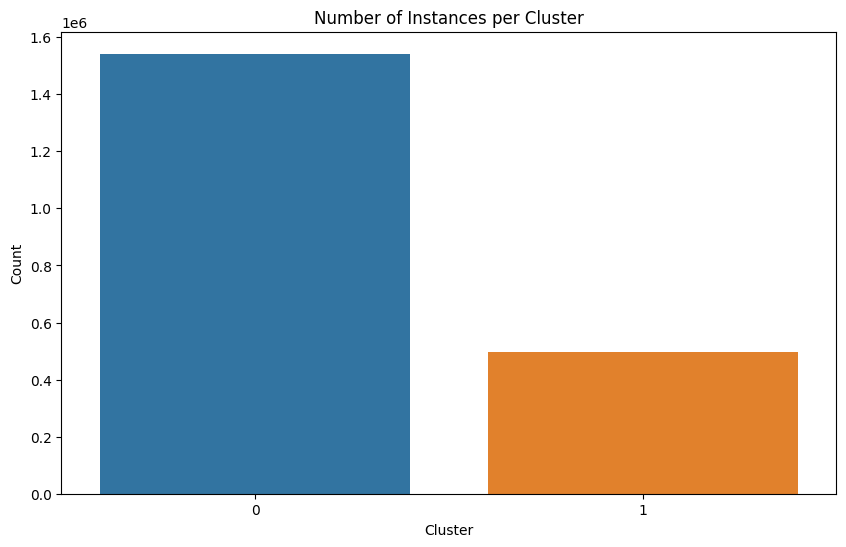

In [47]:
import seaborn as sns

cluster_counts = gm_predictions.groupBy("prediction").count().toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="prediction", y="count", data=cluster_counts)
plt.title('Number of Instances per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


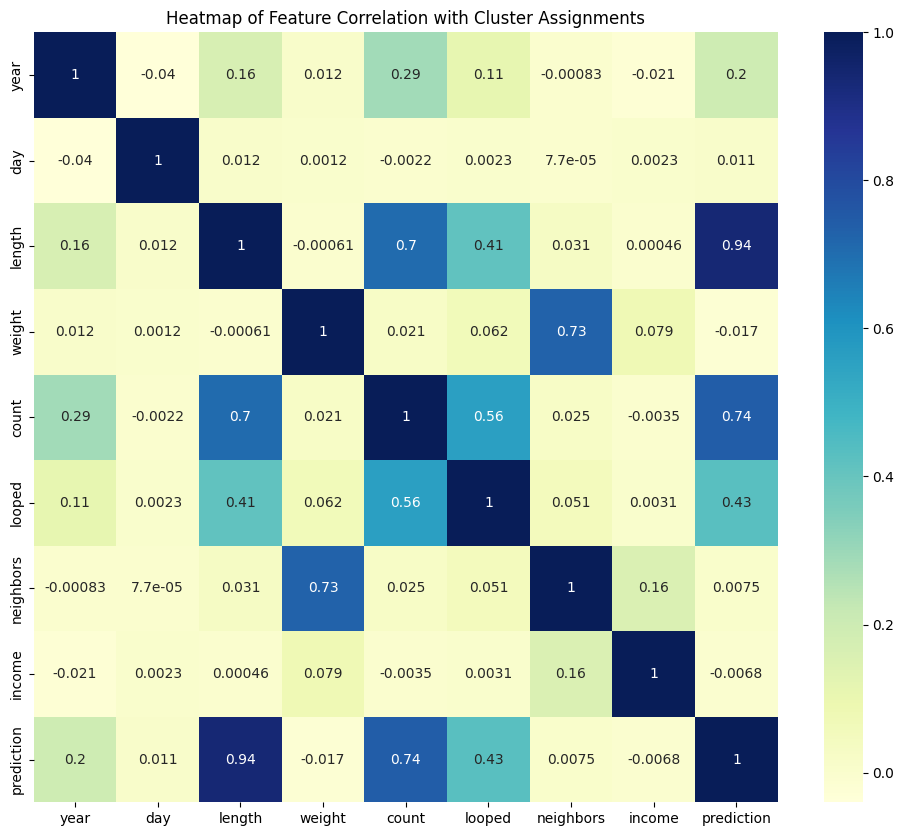

In [48]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

features_with_clusters = features + ["prediction"]

assembler = VectorAssembler(inputCols=features_with_clusters, outputCol='features_with_clusters')

vector_df = assembler.transform(gm_predictions)

pearsonCorr = Correlation.corr(vector_df, "features_with_clusters").head()[0]

corr_df = pd.DataFrame(pearsonCorr.toArray(), columns=features_with_clusters, index=features_with_clusters)

import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(corr_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Feature Correlation with Cluster Assignments')
plt.show()

In [49]:
gm_predictions_test = gmm.transform(test_data)

comparison_df_test = gm_predictions_test.join(original_df, on='address', how='inner')

comparison_df_test = comparison_df_test.withColumn(
    'original_cluster',
    when(comparison_df_test['label'] == 'white', 0).otherwise(1)
)

accuracy_test = comparison_df_test.filter(comparison_df_test.prediction == comparison_df_test.original_cluster).count() / comparison_df_test.count()
print("Test Accuracy: ", accuracy_test)


Test Accuracy:  0.15292322097378278


In [50]:
comparison_df_test.select('address', 'label', 'prediction').show()

+--------------------+-----+----------+
|             address|label|prediction|
+--------------------+-----+----------+
|11126SM5WRmqGb3sd...|  0.0|         0|
|1112BSHLY8qauCJFN...|  0.0|         0|
|111HypzgSbS3F2WmZ...|  0.0|         0|
|111JbRFCHSWKnngK6...|  0.0|         0|
|111R8uq5SXpySiQMt...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111khWGs3Mj7UgKT7...|  0.0|         0|
|111oiWiKtCGTMZRyS...|  0.0|         0|
|112149G27Jhd6fCRj...|  0.0|         0|
|112198tPGkzw5Asfg...|  0.0|         0|
|1121A3vrYYduVPMnf...|  0.0|         0|
|1121A3vrYYduVPMnf...|  0.0|         0|
|1121A3vrYYduVPMnf...|  0.0|         0|
|1121A3vrYYduVPMnf...|  0.0|         0|
+--------------------+-----+----------+
only showing top 20 rows

